# Assignment 1: Building a Machine Learning Pipeline

Ari Anisfeld

In [28]:
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import pipeline.util as u
import pipeline.process as pr
import pipeline.read as r
import pipeline.explore as x
import pipeline.evaluate as ev
% matplotlib inline


In [3]:
data = r.read_csv('data/credit-data.csv', parse_zipcodes=["zipcode"], dtype ={"SeriousDlqin2yrs": "category","PersonID":"category"})
data.serious_dlqin2yrs.cat.categories = ["Nondelinquent", "Delinquent"]



# Explore Data

The below table shows outcomes split by data labeled delinquent or nondelinquent. The number of times delinquents are past due is an order of magnitude higher than nondelinquents, but the high variance on the measure and low median suggest that is driven by people with particularly high numbers of past due bills. Nondelinquents are older and have higher income on average.

In [4]:
summary = x.summary_by_outcome(data, "serious_dlqin2yrs")

summary.ix[:,[0,1,2,4,6,7,8,10]]

serious_dlqin2yrs                           Nondelinquent                     \
                                                    count     mean       std   
age                                              139974.0    52.75     14.79   
debt_ratio                                       139974.0   357.15   2083.28   
monthly_income                                   111912.0  6747.84  14813.50   
number_of_dependents                             136229.0     0.74      1.11   
number_of_open_credit_lines_and_loans            139974.0     8.49      5.11   
number_of_time30-59_days_past_due_not_worse      139974.0     0.28      2.95   
number_of_time60-89_days_past_due_not_worse      139974.0     0.13      2.90   
number_of_times90_days_late                      139974.0     0.14      2.91   
number_real_estate_loans_or_lines                139974.0     1.02      1.11   
revolving_utilization_of_unsecured_lines         139974.0     6.17    256.13   

serious_dlqin2yrs                                    Delinquent           \
                                                 50%      count     mean   
age                                            52.00    10026.0    45.93   
debt_ratio                                      0.36    10026.0   295.12   
monthly_income                               5466.00     8357.0  5630.83   
number_of_dependents                            0.00     9847.0     0.95   
number_of_open_credit_lines_and_loans           8.00    10026.0     7.88   
number_of_time30-59_days_past_due_not_worse     0.00    10026.0     2.39   
number_of_time60-89_days_past_due_not_worse     0.00    10026.0     1.83   
number_of_times90_days_late                     0.00    10026.0     2.09   
number_real_estate_loans_or_lines               1.00    10026.0     0.99   
revolving_utilization_of_unsecured_lines        0.13    10026.0     4.37   

serious_dlqin2yrs                                              
                                                 std      50%  
age                                            12.92    45.00  
debt_ratio                                   1238.36     0.43  
monthly_income                               6171.72  4500.00  
number_of_dependents                            1.22     0.00  
number_of_open_credit_lines_and_loans           5.65     7.00  
number_of_time30-59_days_past_due_not_worse    11.73     0.00  
number_of_time60-89_days_past_due_not_worse    11.75     0.00  
number_of_times90_days_late                    11.76     0.00  
number_real_estate_loans_or_lines               1.43     1.00  
revolving_utilization_of_unsecured_lines      131.84     0.84

In [5]:
null_income = u.check_nulls(data, "monthly_income")
null_sum = x.summary_by_outcome(null_income, "serious_dlqin2yrs")

not_null_income = u.get_notnulls(data, "monthly_income")
not_null_sum = x.summary_by_outcome(not_null_income, "serious_dlqin2yrs")
ratio = round(null_sum.ix[:,[0,1,2,5,6,7,8,11]]/not_null_sum.ix[:,[0,1,2,5,6,7,8,11]],2)
ratio.drop("monthly_income")

serious_dlqin2yrs                           Nondelinquent                      \
                                                    count   mean    std   max   
age                                                  0.25   1.10   1.06  1.06   
debt_ratio                                           0.25  62.04  10.12  5.39   
number_of_dependents                                 0.22   0.37   0.70  0.45   
number_of_open_credit_lines_and_loans                0.25   0.83   0.94  0.78   
number_of_time30-59_days_past_due_not_worse          0.25   1.31   1.85  1.00   
number_of_time60-89_days_past_due_not_worse          0.25   2.40   1.89  1.00   
number_of_times90_days_late                          0.25   2.27   1.88  1.00   
number_real_estate_loans_or_lines                    0.25   0.83   0.92  0.43   
revolving_utilization_of_unsecured_lines             0.25   1.08   0.82  0.44   

serious_dlqin2yrs                           Delinquent                     
                                                 count   mean   std   max  
age                                               0.20   1.01  1.09  0.98  
debt_ratio                                        0.20  77.49  6.67  1.86  
number_of_dependents                              0.18   0.37  0.75  0.75  
number_of_open_credit_lines_and_loans             0.20   0.74  0.94  0.60  
number_of_time30-59_days_past_due_not_worse       0.20   2.32  1.90  1.00  
number_of_time60-89_days_past_due_not_worse       0.20   3.00  1.91  1.00  
number_of_times90_days_late                       0.20   2.74  1.90  1.00  
number_real_estate_loans_or_lines                 0.20   0.69  0.78  0.52  
revolving_utilization_of_unsecured_lines          0.20   2.17  2.12  1.35

The analysis above compares people who have a reported monthly income and those with null monthly incomes. The ratio of missing income data over debt ratio with income data is very large. Those without income data have 62 to 77 times the debt ratio of those with reported data. In general, we would hope these ratios were close to 1. The count data show for each person with missing data there are 4 to 5 people with reported income. In other words, those with missing data make up slightly under 20 percent of our data. I will have to be careful when developing models to account for this discrepancy. For example, in a large project I would compare models with imputed values for the missing income data with dropping the data and would consider capping debt ratios. The graphs below show that the data with nulls has more extreme debt ratios (compare the bottom corners of the following two pair plots). The solution is I will implement will be to group debt ratios.

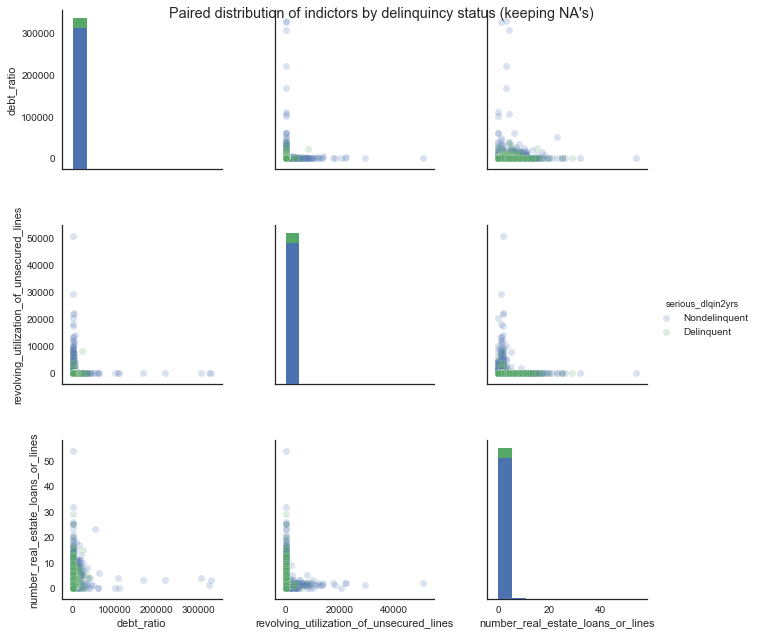

In [47]:
sns.set(style="white")
sns.pairplot(data, vars=["debt_ratio","revolving_utilization_of_unsecured_lines","number_real_estate_loans_or_lines"],\
             hue="serious_dlqin2yrs", size=3, plot_kws={'alpha':0.2})
pl.suptitle("Paired distribution of indictors by delinquincy status (keeping NA's)")

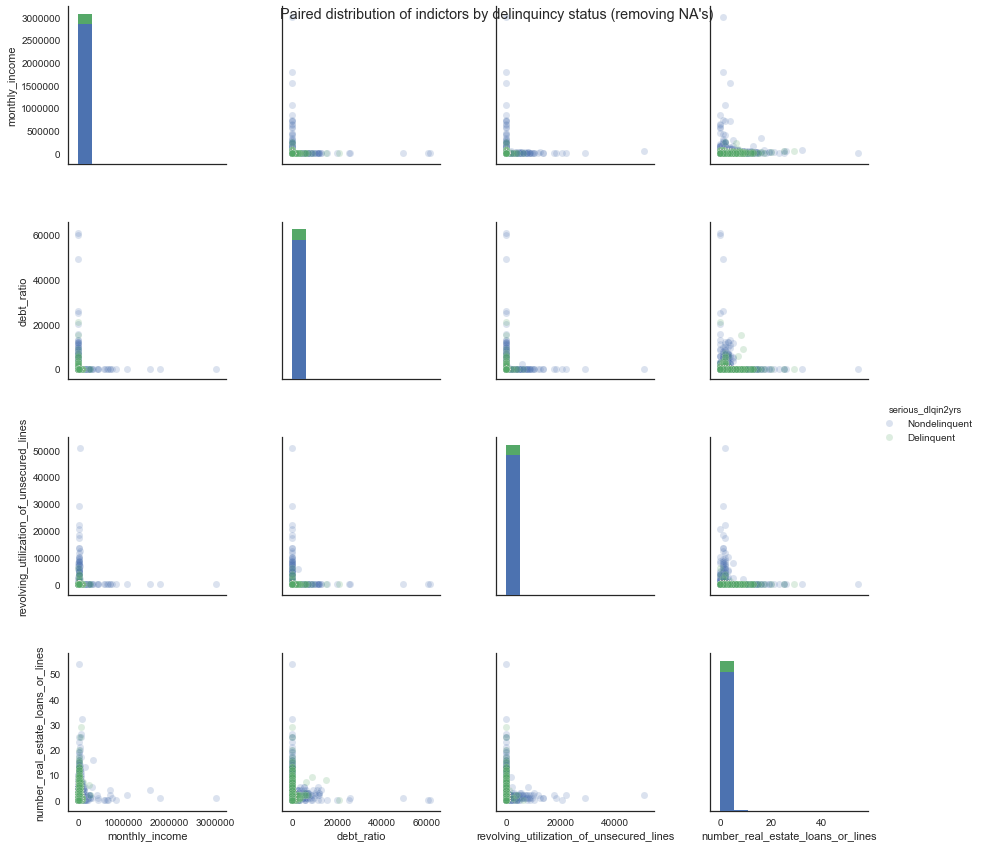

In [48]:
sns.pairplot(u.get_notnulls(data,"monthly_income"), vars=["monthly_income","debt_ratio","revolving_utilization_of_unsecured_lines","number_real_estate_loans_or_lines"],\
             hue="serious_dlqin2yrs", size=3, plot_kws={'alpha':0.2})
pl.suptitle("Paired distribution of indictors by delinquincy status (removing NA's)")


# Correlation Plot

The correlation plot shows very strong correlation between the different past-due categories. While age and number of open credit lines and loans are weakly negatively correlated with the past-due categories and uncorrelated with debt ratios, income and number of dependents. Debt ratios, income and number of dependents are postively correlated with number of open credit lines and real estate loans.

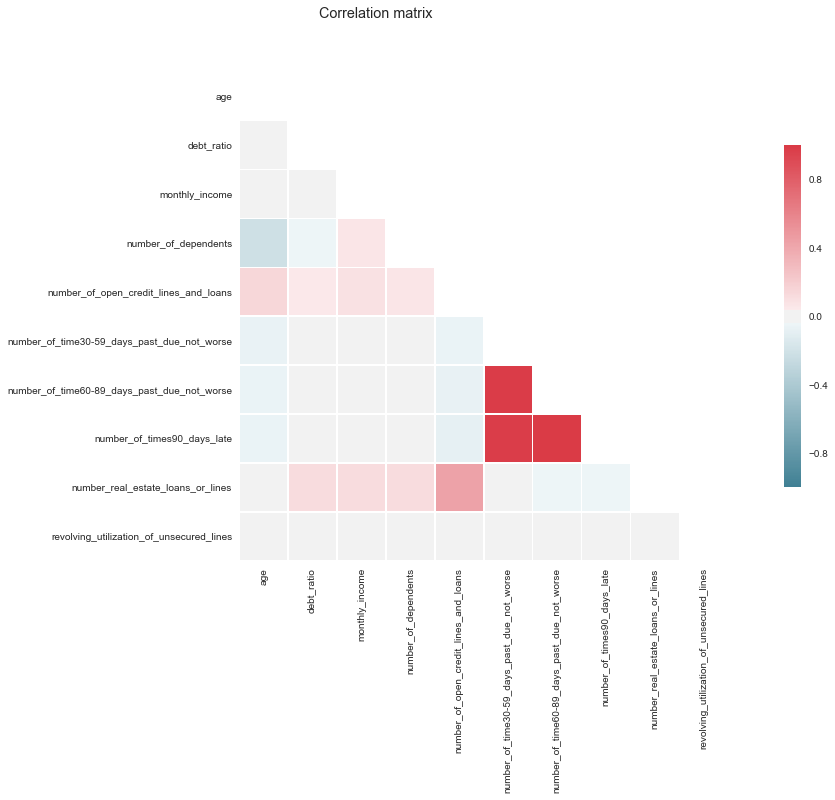

In [49]:
x.correlation_plot(data)
pl.suptitle("Correlation matrix")

In [25]:
print("Table: Average feature values by zip code")
x.summary_by_outcome(data, "zipcode").iloc[:,1::6]

Table: Average feature values by zip code


zipcode,60601,60618,60625,60629,60637,60644,60657,60804
,mean,mean,mean,mean,mean,mean,mean,mean
age,52.28,52.27,52.33,52.18,52.25,52.22,52.41,52.40
debt_ratio,341.85,342.50,360.24,345.67,338.03,373.64,357.01,357.87
monthly_income,6686.20,6686.42,6616.10,6628.62,6805.49,6595.88,6635.17,6764.87
number_of_dependents,0.76,0.75,0.76,0.76,0.76,0.77,0.76,0.74
number_of_open_credit_lines_and_loans,8.56,8.44,8.45,8.39,8.43,8.46,8.47,8.41
number_of_time30-59_days_past_due_not_worse,0.39,0.42,0.41,0.40,0.46,0.40,0.39,0.51
number_of_time60-89_days_past_due_not_worse,0.20,0.24,0.23,0.22,0.27,0.22,0.22,0.33
number_of_times90_days_late,0.22,0.27,0.26,0.24,0.30,0.25,0.24,0.36
number_real_estate_loans_or_lines,1.02,1.02,1.03,1.01,1.02,1.01,1.02,1.01


On average, we do not see major difference betweeen zip codes, despite representing very differen Chicago neighborhoods. Revolving utilization of unsecured lines is the exception. The results were similar when looking at median. Most zipcodes hovered around 16600 residents in the sample, while 60625 zipcode had double that. Despite this, in the feature generation section, I hoped to make dummies of these. I ran into memory issues however, even after reducing the size of the stored integers and using sparse matrices.

# Feature Generation

In [4]:
data["debt_ratio_groups"] = pr.cut(data.debt_ratio, [0,0.25,.5,.75,1], labels="auto")

# This apply function is too slow.
#data.debt_ratio = data.debt_ratio.apply(lambda x: pr.cap_values(x,data.debt_ratio.quantile(.99)))


In [5]:
na_cols = ["monthly_income","number_of_dependents"]
data[na_cols] = pr.fill_with_mean(df=data,col=na_cols, group="serious_dlqin2yrs")


In [6]:
data.number_of_dependents.value_counts()

data["number_of_dependents_cut"] = pr.cut(data.number_of_dependents, [0,.99,3.01,20.1], \
                                          method=pd.cut, labels=["No dependents","1-3 dependents", "4+ dependents"],include_lowest=True)
data = pr.get_dummies(data.number_of_dependents_cut, data)

# Build Model

In [23]:
#sample = u.get_subsample(data, 5000)


features = ["No dependents","1-3 dependents", "4+ dependents","debt_ratio_groups",\
            "monthly_income","number_of_time30-59_days_past_due_not_worse"]

X = data[features]
y = data.serious_dlqin2yrs
class_names = data.serious_dlqin2yrs.unique()

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [24]:
clf = svm.SVC()
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
y_hat = clf.predict(X_test)

Confusion matrix, without normalization
[[  447  2100]
 [   24 34929]]
Normalized confusion matrix
[[  1.76e-01   8.24e-01]
 [  6.87e-04   9.99e-01]]


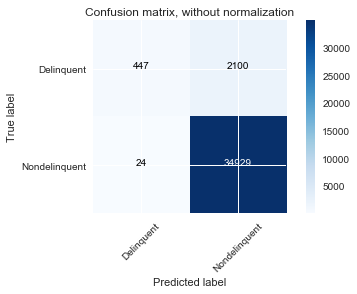

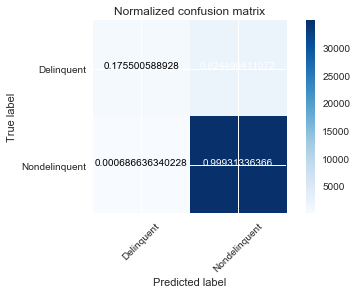

In [29]:
#import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
pl.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure()
ev.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

pl.show()

In [30]:
ev.get_accuracy(cnf_matrix)

0.94335999999999998

In [32]:
ev.get_recall(cnf_matrix)

0.17550058892815076

In [34]:
ev.get_precision(cnf_matrix)

0.94904458598726116

# Analysis of Model

I ran my features through a support vector machine, which is a reasonable model for a classification problem like this. The accuracy of the model was 94.3 percent. For perspective, if we just guessed that every person was nondelinquent, we would have accuracy of 93.3 percent. The precision was 95 percent, but the recall of 17.6 percent captures the short coming of the model. Our goal was to identify potentially delinquent people and support them through some sort of policy initive. In this case, we miss most people.